# Assessing significance of neutral objectives in League of Legends

### Table of contents

1. [Loading and saving libraries/data](#load)

2. [Querying Riot's API](#query)

3. [Explore data](#explore)

4. [Machine learning](#machine)

League of legends is a 5v5 multiplayer strategy game where the winning team must destroy enemy structures. Outside of the direct winning objectives, there are neutral objectives that either team can capture in order to gain temporary or permanent buffs: dragons, rift heralds, and baron nashors. The relative benefits and importance of these neutral monster objectives are widely debated.

Here I construct a basic model for predicting the game winner based on post-game information. This model helps inform which neutral objectives are most predictive of the winner.

This project was based on 20,000 NA high elo ranked matches, based on matches from masters, Grandmasters, and Challenger tier players in the North American server.

There are two parts to this project:
1. Make a predictive model for predicting the winner of a game at different times of a game
    - precision and f1-score will be used to evaluate the effectiveness of the trained model
2. Assess the relative importance of neutral objectives to predicting game outcomes
    - feature importance weights will be extracted from the trained model

<a id='load'></a>
### Loading libraries and data, saving data

In [953]:
import requests, json
import numpy as np
import importlib
import pandas as pd
import pickle
import os

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
import pdb
import warnings
warnings.filterwarnings('ignore')

In [740]:
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier

In [647]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [14]:
from riotwatcher import LolWatcher, ApiError

In [61]:
#text_file = open("high_elo_accIds.txt", "w")
#text_file.write()
#text_file.close()

In [174]:
#pickle/save file
import pickle
with open('data/high_elo_accIds.pkl', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(high_elo_accIds, filehandle)

In [ ]:
#load file
with open('data/high_elo_accIds.pkl', 'rb') as filehandle:
    # read the data as binary data stream
    high_elo_accIds = pickle.load(filehandle)

In [186]:
def pkl_file(filename, filepath):
    with open(filepath, 'wb') as filehandle:
        # store the data as binary data stream
        pickle.dump(filename, filehandle)

def load_pkl(filename, filepath):
    with open(filepath, 'rb') as filehandle:
        # read the data as binary data stream
        filename = pickle.load(filehandle)

def save_txt(filename, filepath):
    f = open(filepath,"w")
    f.write( filename )
    f.close()

In [613]:
save_txt(str(match_stats_dict), 'data/match_stats_dict.txt')

In [585]:
pkl_file(match_dict, 'data/match_dict.pkl')

In [678]:
pkl_file(match_detail_dict, 'data/match_detail_dict.pkl')

In [679]:
pkl_file(match_stats_dict, 'data/match_stats_dict.pkl')

In [910]:
pkl_file(match_timeline_dict, 'data/match_timeline_dict.pkl')

In [908]:
df.to_csv('data/match_stats_df.csv')

In [208]:
def rand(to_shuffle):
    '''
    Shuffle a copy without disturbing original list
    '''
    shuffled_copy = to_shuffle.copy()
    random.shuffle(shuffled_copy)
    return shuffled_copy

<a id='query'></a>
# Extracting data from Riot API: 

## Summoner names

Get a list of players in high elo ranks (Master, Grandmaster, Challenger)

In [4]:
with open('api_key.txt', 'r') as api_file:
    api_key =  api_file.read()

In [593]:
# golbal variables
api_key = 'RGAPI-14651911-2597-416c-9c96-63fa72f1a5bb'
watcher = LolWatcher(api_key)
my_region = 'na1'
queue_type = 'RANKED_SOLO_5x5'

In [41]:
feat_games = watcher.spectator.featured_games(my_region)

In [27]:
#get list of high elo players
chall_players = watcher.league.challenger_by_queue(my_region, queue_type)
master_players = watcher.league.masters_by_queue(my_region, queue_type)
GM_players = watcher.league.grandmaster_by_queue(my_region, queue_type)

In [50]:
#compile list of summoner IDs for list of high elo players
high_elo_summonerIds = []
for entry in chall_players['entries']:
    high_elo_summonerIds.append(entry['summonerId'])
for entry in master_players['entries']:
    high_elo_summonerIds.append(entry['summonerId'])
for entry in GM_players['entries']:
    high_elo_summonerIds.append(entry['summonerId'])

In [47]:
chall_players

{'tier': 'CHALLENGER',
 'leagueId': 'c60807e8-6afb-38fd-ab9b-ae8588dc8b27',
 'queue': 'RANKED_SOLO_5x5',
 'name': "Kha'Zix's Warriors",
 'entries': [{'summonerId': 'aKgW_wqkTJ-nkuMnAzmcNjdlsWCFRlACgLFdttNBWvKcZIc',
   'summonerName': 'Kandori',
   'leaguePoints': 841,
   'rank': 'I',
   'wins': 224,
   'losses': 187,
   'veteran': True,
   'inactive': False,
   'freshBlood': False,
   'hotStreak': False},
  {'summonerId': 'bE44fVre61r8szwuoOjlDx3_29SkNDH9qslIPoIX6MdNQXyN',
   'summonerName': 'ADCADC123',
   'leaguePoints': 1160,
   'rank': 'I',
   'wins': 344,
   'losses': 277,
   'veteran': True,
   'inactive': False,
   'freshBlood': False,
   'hotStreak': False},
  {'summonerId': 'KouvFsnpxQ9H91W09mioR_0-qS0wduVKPLpjnIZUWdLuT3to',
   'summonerName': 'Kral Closer',
   'leaguePoints': 979,
   'rank': 'I',
   'wins': 313,
   'losses': 268,
   'veteran': True,
   'inactive': False,
   'freshBlood': False,
   'hotStreak': True},
  {'summonerId': 'QhGwGPOLg2fT2wdonRDW-LdFok_2Ebr-zeYOHO42w

In [46]:
chall_players['entries'][0]

{'summonerId': 'aKgW_wqkTJ-nkuMnAzmcNjdlsWCFRlACgLFdttNBWvKcZIc',
 'summonerName': 'Kandori',
 'leaguePoints': 841,
 'rank': 'I',
 'wins': 224,
 'losses': 187,
 'veteran': True,
 'inactive': False,
 'freshBlood': False,
 'hotStreak': False}

## Account ID

Convert summoner ID's to account ID's (to use for obtaining match IDs later)

In [55]:
watcher.summoner.by_id(my_region, 'aKgW_wqkTJ-nkuMnAzmcNjdlsWCFRlACgLFdttNBWvKcZIc')['accountId']

'_JBrw5ZEaW9y9ABf2VQ9Zwul4lJmTngiuVsm7XznoKHxOw'

In [65]:
test_accId = '_JBrw5ZEaW9y9ABf2VQ9Zwul4lJmTngiuVsm7XznoKHxOw'

In [56]:
%%time
#convert summoner IDs into account IDs to obtain match IDs later
high_elo_accIds = []
for summonerID in high_elo_summonerIds:
    high_elo_accIds.append(watcher.summoner.by_id(my_region, summonerID)['accountId'])

In [57]:
len(high_elo_accIds)

1255

In [58]:
high_elo_accIds

['_JBrw5ZEaW9y9ABf2VQ9Zwul4lJmTngiuVsm7XznoKHxOw',
 'hp3wQzf0Qcs5Fnj45_P0AUXBz7-DAYnJUYWKrcbSwCh8urCBpHG-GrrS',
 '29IxleXM4jPS5T2KmsFdxcbZFZlCCzD4-OQxXI4gURHVse8nyP_OYfYc',
 'DDzNcXIIaSnXqjFJWjvaOtOqRQoXiohNDAAF9Vv7tU0Gt1k',
 'DmIsL2U_YfkFvgPHAaNc7gnnei2xALo0CxikkoQ0SGjYhMU',
 'vKZQmQbwbaA2KWAhnK_pX8CI-G54swj6jHPvB32iIk03aA',
 'p-FDVXL2PVCuWf4-NyWOwfJsUsTwkmTsdvexpCUwRr0Rqf2J1Siq9IQx',
 'XYHw7RBsdt4zKlz6vBy6Azhst8yjFubcHSfLcfgt21_m0Q',
 '49ktgxVhbcxyTXpK-5F4lhsCRzEyLocg7aVKeqy9_Q',
 'GDjOrucdAH-Eydcm7Rdjmht69RbnVJ-dCLP9gstfMuqndj4',
 'Wfr7qym3OXhzMhjBxqNzo3N-L0HfHhW0_j4ywWuW7L0XbA',
 'mq9jRuXgZNXVxDKDMc92HPMZPSmHFF5dNdAbZAMIjntINzk',
 'GjCSfQ1jcIzOrQ49U8n9oUQaQRBPXpl2Jaj232tQq24xMJAQedSNnoRB',
 'NGYs92mmMn4U0WnZeYx8X10DlamLMOAKlbLOvLHXVx9YtwE',
 '3-TmucbFNpODk8hOqAX50o8gVvzUlgFWcHlAy9o2X7L6g70',
 '1eYnztK2x432-JeNev1eiDIMqLKWFtlE21IINb6pG2XWQs0Z1hq24gjW',
 'xOlB6nXvNMjW-h81jpuU0bkzwadmidIydQLUcppsRI0RJVA',
 'vOOeJ_pye8EbVBPcKOeP9LXDIZQ92z6cb6Sxza_k1rR5mw',
 'BK3NHYNRh0EXUz7SgaucgbDn79d

In [62]:
#since the summoners extracted by rank, randomize list to reduce chance of bias
import random
unordered_accIds = high_elo_accIds.copy()
random.shuffle(unordered_accIds)

In [63]:
unordered_accIds

['RnUXqlcP4OlBPCbrSKoAxsHtDmaNafqfAEd6_WDTcMQ-6gTrD-xjfS-6',
 'jyGwEUPhn4LIoL-MDW15jpug3c3vTEi-TF-6JZaLIo3Uh7RgpGMA6zOQ',
 'oyZh8APFpeMuaSNjzHo9GOkIhlHnilk2jwM0AzzWlcdmAg',
 '_Xp0EnkmOv20Sb5D8cdCWiesDpw14i5tnQbTDGc3dcsROg',
 'hJn4wTkJszvRVi-j1m52OhydZ6JZ93D0puqqN111XW52tiMBq20N7bXo',
 '7EFoYbzJJVBzk2CPC_fdkTQ5xS_LLGYoxRC5QCwpljF9hzk',
 'L6p1svYEiPHFZ1cHeUZnNEwApCpcGk9v-hOE0YltcShOo1hP85eJdVyf',
 'm5CgWtjAl6qHwB0-52nmGAWPzkG7khFlCpVOEqqAFeSGkQ',
 '7kGR7NMehaF3WzQooW_WfYPYuNDRW8ktMAKah64-e3caJoQ',
 'Q8r5ILpE4ncPzl6xVgzoZ6_4SAKKN3M5Pwnu-292Bf-2JWc',
 '6SC1rPBNQ-jHCzyjwLA3YmfPN11JfrPEiGzVJ6foXNg',
 'HmKihDpDOtwTEWbuv7VoaumVpk8i8JEFE9BRw9pNgChKiyc',
 'wLBt3Av_w0TfRz5sUkDlt7XyAz8iYb9NmUx2jV_kLhp2hbM',
 'Pu-MvEKxoqIRUpP_cCgggBr9U_SGgndDSDHdyOSqGqwWt9M',
 'ClK13mMxV6HODIQTi2wWO65j9ajuWafKOMV7vd1WRq5LQw',
 'JPTlNSPJI09TI7W5OfMTkcjYk2Il-7esHNlg_pM_lIjQ2A',
 '_bg48Jwj7oKJ1sEd4z32wxvLOUx1HxV2mCNWASKBcwxFmw',
 'CUNU6EgKyFVAgrykbwJFLihI4NoJzuatvB_eCJyeRALkiuM',
 '_sPMOEJQ8lyc8vXpTdP7s_JqhXhOgeyioGzi

In [155]:
#create a randomized list to reduce  any chance of bias
import random
unordered_accIds = high_elo_accIds.copy()
random.shuffle(unordered_accIds)

## Matchs
Compile list of most recent 100 matches for each account ID, then compile the match IDs into a single list of account IDs with no duplicates.

In [160]:
%%time
#for all players in high elo, find the match IDs of their most recent games and compile to a set. 
#match_dict = {} #initialize new dictionary

#for each account ID, find a list of their ??10??20?? of their most recent matches 
#and save it to a new dictionary

for acc_ID in unordered_accIds:
    if acc_ID not in match_dict.keys():
        my_matches = watcher.match.matchlist_by_account(my_region, acc_ID)['matches']
        my_matches_list = list(x['gameId'] for x in my_matches)
        #my_matches_list = []
        #for i in range(len(my_matches)):
            #my_matches_list.append(my_matches[i]['gameId'])
        match_dict[acc_ID] = my_matches_list

Wall time: 10min 23s


In [171]:
matchlist = set()
for acc_ID in match_dict:
    matchlist.update(match_dict[acc_ID])

In [172]:
len(matchlist)

67519

In [190]:
matchlist = list(matchlist)

In [ ]:
my_matches = watcher.match.matchlist_by_account(my_region, me['accountId'])

In [69]:
my_matches = watcher.match.matchlist_by_account(my_region, test_accId)['matches']
my_matches

[{'platformId': 'NA1',
  'gameId': 3447355549,
  'champion': 115,
  'queue': 400,
  'season': 13,
  'timestamp': 1591160342189,
  'role': 'DUO_CARRY',
  'lane': 'BOTTOM'},
 {'platformId': 'NA1',
  'gameId': 3447347793,
  'champion': 412,
  'queue': 450,
  'season': 13,
  'timestamp': 1591158041136,
  'role': 'SOLO',
  'lane': 'BOTTOM'},
 {'platformId': 'NA1',
  'gameId': 3447015320,
  'champion': 246,
  'queue': 420,
  'season': 13,
  'timestamp': 1591143391496,
  'role': 'DUO_SUPPORT',
  'lane': 'NONE'},
 {'platformId': 'NA1',
  'gameId': 3446937263,
  'champion': 246,
  'queue': 420,
  'season': 13,
  'timestamp': 1591139877306,
  'role': 'SOLO',
  'lane': 'MID'},
 {'platformId': 'NA1',
  'gameId': 3446970246,
  'champion': 246,
  'queue': 420,
  'season': 13,
  'timestamp': 1591137387186,
  'role': 'SOLO',
  'lane': 'MID'},
 {'platformId': 'NA1',
  'gameId': 3446912575,
  'champion': 55,
  'queue': 420,
  'season': 13,
  'timestamp': 1591133624486,
  'role': 'SOLO',
  'lane': 'MID'}

In [70]:
my_matches_list = list(x['gameId'] for x in my_matches)

In [71]:
my_matches_list

[3447355549,
 3447347793,
 3447015320,
 3446937263,
 3446970246,
 3446912575,
 3446855076,
 3446564676,
 3446433775,
 3446382969,
 3446265550,
 3446242002,
 3446226114,
 3444752826,
 3444672632,
 3443958873,
 3443901158,
 3443799401,
 3443831158,
 3443368198,
 3443340240,
 3443139498,
 3442877316,
 3441767271,
 3441813815,
 3441772095,
 3441718344,
 3438295929,
 3438264800,
 3438198574,
 3438204757,
 3438072464,
 3437956759,
 3437904969,
 3437941842,
 3437548546,
 3437531203,
 3436969894,
 3436496383,
 3436362101,
 3436323645,
 3436191324,
 3435645707,
 3435652738,
 3435621194,
 3435548984,
 3435575298,
 3434993779,
 3434216162,
 3434205234,
 3434204056,
 3434222158,
 3434210648,
 3434156847,
 3434161784,
 3434038466,
 3433898782,
 3433688558,
 3433681845,
 3433347305,
 3433330722,
 3432610494,
 3432421088,
 3430911015,
 3430837933,
 3429983152,
 3429919709,
 3429895051,
 3429351211,
 3429241006,
 3428771055,
 3428668239,
 3428694955,
 3428702571,
 3428679989,
 3428593863,
 3428385614,

In [73]:
test_gameId = 3447355549

### Match details

In [560]:
match_stats

{'Winner': 'red',
 'blueElemDragNum': 4,
 'blueFIRE_DRAGON': 1,
 'redElemDragNum': 0,
 'redFIRE_DRAGON': 0,
 'drag1type': 'FIRE_DRAGON',
 'drag1team': 'blue',
 'drag1time': 372155,
 'blueWATER_DRAGON': 1,
 'redWATER_DRAGON': 0,
 'drag2type': 'WATER_DRAGON',
 'drag2team': 'blue',
 'drag2time': 694819,
 'RIFTHERALD1team': 'red',
 'RIFTHERALD1time': 899295,
 'blueAIR_DRAGON': 2,
 'redAIR_DRAGON': 0,
 'drag3type': 'AIR_DRAGON',
 'drag3team': 'blue',
 'drag3time': 1012964,
 'SoulType': 'AIR_DRAGON',
 'SoulTeam': 'blue',
 'drag4type': 'AIR_DRAGON',
 'drag4team': 'blue',
 'drag4time': 1353936,
 'drag5type': 'ELDER_DRAGON',
 'drag5team': 'blue',
 'drag5time': 1824420,
 'firstTower': 'red',
 'firstInhibitor': 'red',
 'firstDragon': 'red',
 'firstRiftHerald': 'blue',
 'bluebaronKills': 0,
 'redbaronKills': 0,
 'blueriftHeraldKills': 1,
 'redriftHeraldKills': 0}

In [75]:
match_detail = watcher.match.by_id(my_region, test_gameId)
match_detail

{'gameId': 3447355549,
 'platformId': 'NA1',
 'gameCreation': 1591160342189,
 'gameDuration': 1968,
 'queueId': 400,
 'mapId': 11,
 'seasonId': 13,
 'gameVersion': '10.11.322.2991',
 'gameMode': 'CLASSIC',
 'gameType': 'MATCHED_GAME',
 'teams': [{'teamId': 100,
   'win': 'Fail',
   'firstBlood': False,
   'firstTower': False,
   'firstInhibitor': False,
   'firstBaron': True,
   'firstDragon': False,
   'firstRiftHerald': True,
   'towerKills': 4,
   'inhibitorKills': 0,
   'baronKills': 1,
   'dragonKills': 1,
   'vilemawKills': 0,
   'riftHeraldKills': 1,
   'dominionVictoryScore': 0,
   'bans': [{'championId': 154, 'pickTurn': 1},
    {'championId': 89, 'pickTurn': 2},
    {'championId': 38, 'pickTurn': 3},
    {'championId': 53, 'pickTurn': 4},
    {'championId': 17, 'pickTurn': 5}]},
  {'teamId': 200,
   'win': 'Win',
   'firstBlood': True,
   'firstTower': True,
   'firstInhibitor': True,
   'firstBaron': False,
   'firstDragon': True,
   'firstRiftHerald': False,
   'towerKills'

In [182]:
#match_detail_dict = {} #initialize match detail dict

HTTPError: 503 Server Error: Service Unavailable for url: https://na1.api.riotgames.com/lol/match/v4/matches/3430810044

In [677]:
len(match_detail_dict)

20275

In [587]:
%%time
#retrieve match details
@retry(stop_max_attempt_number=20, wait_random_min=1000, wait_random_max=2000)
def retrieve_match_detail():
    for gameId in matchlist:
        if gameId not in match_detail_dict.keys():
            match_detail = watcher.match.by_id(my_region, gameId)
            match_detail_dict[gameId] = match_detail

Wall time: 0 ns


In [676]:
%%time
retrieve_match_detail()

From cffi callback <function _verify_callback at 0x000001C0EEDBCF78>:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\OpenSSL\SSL.py", line 311, in wrapper
    @wraps(callback)
KeyboardInterrupt


KeyboardInterrupt: 

In [279]:
# match_timeline_dict = {}  #initialize match timeline dict

### Match Timeline

In [625]:
%%time
len(match_timeline_dict)

Wall time: 1.05 ms


28627

In [287]:
from retrying import retry

In [588]:
@retry(stop_max_attempt_number=20, wait_random_min=1000, wait_random_max=2000)
def retrieve_match_timeline():
    #retrieve match timeline:
    for gameId in matchlist:
        if gameId not in match_timeline_dict.keys():
            match_timeline = watcher.match.timeline_by_match(my_region, gameId)
            match_timeline_dict[gameId] = match_timeline

In [624]:
%%time
retrieve_match_timeline()

HTTPError: 504 Server Error: Gateway Timeout for url: https://na1.api.riotgames.com/lol/match/v4/timelines/by-match/3434010758

In [96]:
match_timeline

{'frames': [{'participantFrames': {'1': {'participantId': 5,
     'position': {'x': 560, 'y': 581},
     'currentGold': 500,
     'totalGold': 500,
     'level': 1,
     'xp': 0,
     'minionsKilled': 0,
     'jungleMinionsKilled': 0,
     'dominionScore': 0,
     'teamScore': 0},
    '2': {'participantId': 1,
     'position': {'x': 560, 'y': 361},
     'currentGold': 500,
     'totalGold': 500,
     'level': 1,
     'xp': 0,
     'minionsKilled': 0,
     'jungleMinionsKilled': 0,
     'dominionScore': 0,
     'teamScore': 0},
    '3': {'participantId': 3,
     'position': {'x': 351, 'y': 293},
     'currentGold': 500,
     'totalGold': 500,
     'level': 1,
     'xp': 0,
     'minionsKilled': 0,
     'jungleMinionsKilled': 0,
     'dominionScore': 0,
     'teamScore': 0},
    '4': {'participantId': 4,
     'position': {'x': 221, 'y': 471},
     'currentGold': 500,
     'totalGold': 500,
     'level': 1,
     'xp': 0,
     'minionsKilled': 0,
     'jungleMinionsKilled': 0,
     'domini

In [547]:
match_obj_dict = {} #iinitialize dict

In [546]:
match_stats_dict = {} #iinitialize dict

In [707]:
bool_params = ['firstTower', 'firstInhibitor', 'firstBaron', 'firstDragon', 
               'firstRiftHerald']
num_params = ['baronKills', 'riftHeraldKills', 'dragonKills']

In [702]:
match_stats_dict3 = {}

# Data Preprocessing

### Extract match info
Exttract relevant match information from the match_details and match_timeline endpoints

In [708]:
%%time
for gameId in matchlist[:20000]:
    
    match_detail = match_detail_dict[gameId] #retrieve game details from dict
    match_stats = {} #initialize dict for game
    #create a key for the game winner
    match_stats['GameDuration'] = match_detail['gameDuration']
    if match_detail['teams'][0]['win'] == 'Win':
        match_stats['Winner'] = 'blue' 
    elif match_detail['teams'][1]['win'] == 'Win':
        match_stats['Winner'] = 'red' 

    #store bool params in match details
    for param in bool_params:
        if match_detail['teams'][0][param] == True:
            match_stats[param] = 'blue'
        elif match_detail['teams'][1][param] == True:
            match_stats[param] = 'red'

    #store num params in match details
    for param in num_params:
        match_stats['blue'+param] = match_detail['teams'][0][param]
        match_stats['red'+param] = match_detail['teams'][1][param]


    match_timeline = match_timeline_dict[gameId]
    #create a key for objective stats
    match_obj = []
    for i in range(len(match_timeline['frames'])):
        for event in match_timeline['frames'][i]['events']:
            #type == 'ELITE_MONSTER_KILL'
            if event['type'] == 'ELITE_MONSTER_KILL':
                if event['killerId'] == 0:
                    pass
                elif event['killerId'] > 0:
                    obj = {}
                    obj['ObjectiveType'] = event['monsterType']
                    if event['monsterType'] == 'DRAGON':
                        obj['DragElement'] = event['monsterSubType']
                    obj['timestamp'] = event['timestamp']
                    if 1<= event['killerId'] <= 5:
                        obj['team'] = 'blue'
                    elif 6<= event['killerId'] <= 10:
                        obj['team'] = 'red'
                    match_obj.append(obj)

    match_obj_dict[gameId] = match_obj
    if len(match_obj) > 0:
        obj_timeline_df = pd.DataFrame(match_obj)

        if obj_timeline_df[obj_timeline_df['ObjectiveType'] == 'DRAGON'].shape[0] > 0:
            
            #store team+timestamp of any elder dragons
            elder_drag_df = obj_timeline_df[obj_timeline_df['DragElement'] == 'ELDER_DRAGON'].reset_index()
            for row_idx, row in elder_drag_df.iterrows():
                match_stats[str(row_idx+1)+'ELDER_DRAGONteam'] = row['team']
                match_stats[str(row_idx+1)+'ELDER_DRAGONtime'] = row['timestamp']
            
            elem_drag_df = obj_timeline_df[obj_timeline_df['DragElement'] != 'ELDER_DRAGON'].dropna(axis=0).reset_index()
            #store total# of elemental drakes on each team, soul dragon info, and # of types of drakes for each team
            for side in ['blue', 'red']:
                match_stats[side+'ElemDragNum'] = elem_drag_df[elem_drag_df['team'] == side].shape[0]
                if match_stats[side+'ElemDragNum'] == 4:
                    match_stats[str(elem_drag_df['DragElement'][2])+'Soulteam'] = side
                    match_stats[str(elem_drag_df['DragElement'][2])+'Soultime'] = elem_drag_df[elem_drag_df['team'] == side].reset_index()['timestamp'][3]
                for drag_elem in list(elem_drag_df['DragElement'].unique()):
                    match_stats[str(side+drag_elem)] = elem_drag_df.query('DragElement == @drag_elem and team == @side').shape[0]

            for row_idx, row in elem_drag_df.iterrows():
                match_stats[str(row_idx+1)+str(row['DragElement'])+'team'] = row['team']
                match_stats[str(row_idx+1)+str(row['DragElement'])+'time'] = row['timestamp']

        if obj_timeline_df[obj_timeline_df['ObjectiveType'] != 'DRAGON'].shape[0] > 0:
            #store details about rift heralds and barons killed
            for obj_type in ['RIFTHERALD', 'BARON_NASHOR']:
                #slice the df with the relevant objective
                obj_type_df = obj_timeline_df[obj_timeline_df['ObjectiveType'] == obj_type].reset_index()

                #for each herald/baron, extract the team that killed the objective and the time it occured
                for row_idx, row in obj_type_df.iterrows():
                    match_stats[str(obj_type+str(row_idx+1)+'team')] = obj_type_df['team'][row_idx]
                    match_stats[str(obj_type+str(row_idx+1)+'time')] = obj_type_df['timestamp'][row_idx]
    
    match_stats_dict3 [gameId] = match_stats

Wall time: 12min 42s


In [982]:
X.columns.values

array(['GameDuration', 'firstTower', 'firstInhibitor', 'firstDragon',
       'firstRiftHerald', 'bluebaronKills', 'redbaronKills',
       'blueriftHeraldKills', 'redriftHeraldKills', 'bluedragonKills',
       'reddragonKills', 'blueElemDragNum', 'blueFIRE_DRAGON',
       'blueEARTH_DRAGON', 'redElemDragNum', 'redFIRE_DRAGON',
       'redEARTH_DRAGON', '1FIRE_DRAGONteam', '1FIRE_DRAGONtime',
       '2EARTH_DRAGONteam', '2EARTH_DRAGONtime', 'RIFTHERALD1team',
       'RIFTHERALD1time', 'firstBaron', '1ELDER_DRAGONteam',
       '1ELDER_DRAGONtime', 'blueAIR_DRAGON', 'FIRE_DRAGONSoulteam',
       'FIRE_DRAGONSoultime', 'redAIR_DRAGON', '1AIR_DRAGONteam',
       '1AIR_DRAGONtime', '3FIRE_DRAGONteam', '3FIRE_DRAGONtime',
       '4FIRE_DRAGONteam', '4FIRE_DRAGONtime', 'BARON_NASHOR1team',
       'BARON_NASHOR1time', 'blueWATER_DRAGON', 'redWATER_DRAGON',
       '1WATER_DRAGONteam', '1WATER_DRAGONtime', '2WATER_DRAGONteam',
       '2WATER_DRAGONtime', 'RIFTHERALD2team', 'RIFTHERALD2time',
     

take out all time vars

In [991]:
match_stats_dict4 = {}

In [992]:
%%time
for gameId in matchlist[:20]:
    
    match_detail = match_detail_dict[gameId] #retrieve game details from dict
    match_stats = {} #initialize dict for game
    #create a key for the game winner
    match_stats['GameDuration'] = match_detail['gameDuration']
    if match_detail['teams'][0]['win'] == 'Win':
        match_stats['Winner'] = 'blue' 
    elif match_detail['teams'][1]['win'] == 'Win':
        match_stats['Winner'] = 'red' 

    match_timeline = match_timeline_dict[gameId]
    #create a key for objective stats
    match_obj = []
    for i in range(len(match_timeline['frames'])):
        for event in match_timeline['frames'][i]['events']:
            #type == 'ELITE_MONSTER_KILL'
            if event['type'] == 'ELITE_MONSTER_KILL':
                if event['killerId'] == 0:
                    pass
                elif event['killerId'] > 0:
                    obj = {}
                    obj['ObjectiveType'] = event['monsterType']
                    if event['monsterType'] == 'DRAGON':
                        obj['DragElement'] = event['monsterSubType']
                    obj['timestamp'] = event['timestamp']
                    if 1<= event['killerId'] <= 5:
                        obj['team'] = 'blue'
                    elif 6<= event['killerId'] <= 10:
                        obj['team'] = 'red'
                    match_obj.append(obj)

    match_obj_dict[gameId] = match_obj
    if len(match_obj) > 0:
        obj_timeline_df = pd.DataFrame(match_obj)

        if obj_timeline_df[obj_timeline_df['ObjectiveType'] == 'DRAGON'].shape[0] > 0:
            
            #store team+timestamp of any elder dragons
            drag_df = obj_timeline_df[obj_timeline_df['ObjectiveType'] == 'DRAGON'] #slice df of dragons only
            
            for side in ['blue', 'red']: #does either side have soul
                if elem_drag_df[elem_drag_df['team'] == side].shape[0] == 4:
                    match_stats[str(elem_drag_df['DragElement'][2])+'Soulteam'] = side #team with soul
            for drag_elem in list(drag_df['DragElement'].unique()):
                match_stats[str(drag_elem)+'diff'] = drag_df.query('DragElement == @drag_elem and team == "blue"').shape[0] - drag_df.query('DragElement == @drag_elem and team == "red"').shape[0]

            #for row_idx, row in elem_drag_df.iterrows():
                #match_stats[str(row_idx+1)+str(row['DragElement'])+'team'] = row['team']

        if obj_timeline_df[obj_timeline_df['ObjectiveType'] != 'DRAGON'].shape[0] > 0:
            #store details about rift heralds and barons kill diff
            for obj_type in ['RIFTHERALD', 'BARON_NASHOR']:
                
                #slice the df with the relevant objective
                obj_type_df = obj_timeline_df[obj_timeline_df['ObjectiveType'] == obj_type].reset_index()
                #for each herald/baron, extract the team that killed the objective and the time it occured
                match_stats[str(obj_type)+'diff'] = obj_type_df[obj_type_df['team'] == 'blue'].shape[0] - obj_type_df[obj_type_df['team'] == 'red'].shape[0]
    
    match_stats_dict4 [gameId] = match_stats

Wall time: 495 ms


In [996]:
match_timeline_dict[gameId].keys()

dict_keys(['frames', 'frameInterval'])

In [993]:
match_stats_dict4

{3411673088: {'GameDuration': 1195,
  'Winner': 'red',
  'firstTower': 'red',
  'firstInhibitor': 'red',
  'firstDragon': 'red',
  'firstRiftHerald': 'blue',
  'baronKillsdiff': 0,
  'riftHeraldKillsdiff': 1,
  'dragonKillsdiff': -2,
  'FIRE_DRAGONdiff': -1,
  'EARTH_DRAGONdiff': -1,
  'RIFTHERALDdiff': 1,
  'BARON_NASHORdiff': 0},
 3435528193: {'GameDuration': 1516,
  'Winner': 'blue',
  'firstTower': 'blue',
  'firstInhibitor': 'red',
  'baronKillsdiff': 0,
  'riftHeraldKillsdiff': 0,
  'dragonKillsdiff': 0},
 3447586821: {'GameDuration': 1964,
  'Winner': 'blue',
  'firstTower': 'red',
  'firstInhibitor': 'red',
  'firstBaron': 'blue',
  'firstDragon': 'red',
  'baronKillsdiff': 1,
  'riftHeraldKillsdiff': 0,
  'dragonKillsdiff': -3,
  'AIR_DRAGONdiff': -1,
  'EARTH_DRAGONdiff': -1,
  'FIRE_DRAGONdiff': -2,
  'ELDER_DRAGONdiff': 1,
  'RIFTHERALDdiff': 0,
  'BARON_NASHORdiff': 1},
 3426877449: {'GameDuration': 915,
  'Winner': 'red',
  'firstTower': 'red',
  'firstDragon': 'red',
  '

In [709]:
#convert dict into df with one game per row
df = pd.DataFrame(match_stats_dict3).transpose()

In [806]:
var_soul = ['FIRE_DRAGONSoulteam', 'FIRE_DRAGONSoultime',
            'WATER_DRAGONSoulteam', 'WATER_DRAGONSoultime',
           'AIR_DRAGONSoulteam', 'AIR_DRAGONSoultime',
           'EARTH_DRAGONSoulteam', 'EARTH_DRAGONSoultime']
var_soul_team = ['FIRE_DRAGONSoulteam', 
            'WATER_DRAGONSoulteam', 
           'AIR_DRAGONSoulteam', 
           'EARTH_DRAGONSoulteam']
var_soul_time = ['FIRE_DRAGONSoultime',
'WATER_DRAGONSoultime',
'AIR_DRAGONSoultime',
'EARTH_DRAGONSoultime']

In [807]:
df_clean

,GameDuration,Winner,firstTower,firstInhibitor,firstDragon,firstRiftHerald,bluebaronKills,redbaronKills,blueriftHeraldKills,redriftHeraldKills,...,2ELDER_DRAGONteam,2ELDER_DRAGONtime,7AIR_DRAGONteam,7AIR_DRAGONtime,7WATER_DRAGONteam,7WATER_DRAGONtime,3ELDER_DRAGONteam,3ELDER_DRAGONtime,BARON_NASHOR5team,BARON_NASHOR5time
3411673088,1195,1,1.0,1.0,1.0,0.0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3435528193,1516,0,0.0,1.0,NaN,NaN,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3447586821,1964,0,1.0,1.0,1.0,NaN,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3426877449,915,1,1.0,NaN,1.0,1.0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3419144205,1176,1,1.0,1.0,1.0,0.0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3436877728,2184,1,1.0,1.0,1.0,1.0,0,2,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3422984098,1112,0,0.0,0.0,1.0,0.0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3342243749,1880,1,0.0,1.0,0.0,0.0,0,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3448805286,1105,1,1.0,NaN,1.0,0.0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [814]:
df

,GameDuration,Winner,firstTower,firstInhibitor,firstDragon,firstRiftHerald,bluebaronKills,redbaronKills,blueriftHeraldKills,redriftHeraldKills,...,2ELDER_DRAGONteam,2ELDER_DRAGONtime,7AIR_DRAGONteam,7AIR_DRAGONtime,7WATER_DRAGONteam,7WATER_DRAGONtime,3ELDER_DRAGONteam,3ELDER_DRAGONtime,BARON_NASHOR5team,BARON_NASHOR5time
3411673088,1195,red,red,red,red,blue,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3435528193,1516,blue,blue,red,NaN,NaN,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3447586821,1964,blue,red,red,red,NaN,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3426877449,915,red,red,NaN,red,red,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3419144205,1176,red,red,red,red,blue,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3436877728,2184,red,red,red,red,red,0,2,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3422984098,1112,blue,blue,blue,red,blue,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3342243749,1880,red,blue,red,blue,blue,0,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3448805286,1105,red,red,NaN,red,blue,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
pd.DataFrame.count()

In [847]:
for var in var_soul_team:
    print (df[var].value_counts())

red     518
blue    433
Name: FIRE_DRAGONSoulteam, dtype: int64
red     539
blue    468
Name: WATER_DRAGONSoulteam, dtype: int64
red     521
blue    423
Name: AIR_DRAGONSoulteam, dtype: int64
red     541
blue    461
Name: EARTH_DRAGONSoulteam, dtype: int64


In [859]:
df[var_soul_team]

,FIRE_DRAGONSoulteam,WATER_DRAGONSoulteam,AIR_DRAGONSoulteam,EARTH_DRAGONSoulteam
3411673088,NaN,NaN,NaN,NaN
3435528193,NaN,NaN,NaN,NaN
3447586821,red,NaN,NaN,NaN
3426877449,NaN,NaN,NaN,NaN
3419144205,NaN,NaN,NaN,NaN
...,...,...,...,...
3436877728,NaN,NaN,NaN,NaN
3422984098,NaN,NaN,NaN,NaN
3342243749,NaN,NaN,NaN,NaN
3448805286,NaN,NaN,NaN,NaN


In [857]:
df['FIRE_DRAGONSoulteam'].replace(np.nan, '').str.cat(df['WATER_DRAGONSoulteam'].replace(np.nan, ''))

3411673088       
3435528193       
3447586821    red
3426877449       
3419144205       
             ... 
3436877728       
3422984098       
3342243749       
3448805286       
3427833767       
Name: FIRE_DRAGONSoulteam, Length: 20000, dtype: object

In [866]:
pd.Series(df['FIRE_DRAGONSoulteam'].replace(np.nan, '').astype(str) + df['WATER_DRAGONSoulteam'].replace(np.nan, '').astype(str))

3411673088       
3435528193       
3447586821    red
3426877449       
3419144205       
             ... 
3436877728       
3422984098       
3342243749       
3448805286       
3427833767       
Length: 20000, dtype: object

In [895]:
#create new var of which team obtained dragon soul
s = df[var_soul_team[0]]
for var in var_soul_team[1:]:
    s = s.replace(np.nan, '').astype(str).add(df[var].replace(np.nan, '').astype(str))

In [901]:
s.replace({'':np.nan, 'blue': 0, 'red': 1})

3411673088    NaN
3435528193    NaN
3447586821    1.0
3426877449    NaN
3419144205    NaN
             ... 
3436877728    NaN
3422984098    NaN
3342243749    NaN
3448805286    NaN
3427833767    NaN
Length: 20000, dtype: float64

In [904]:
df['soul_team'] = s.replace({'':np.nan})

In [907]:
df['GameDuration'].max()

3507

In [905]:
df

,GameDuration,Winner,firstTower,firstInhibitor,firstDragon,firstRiftHerald,bluebaronKills,redbaronKills,blueriftHeraldKills,redriftHeraldKills,...,2ELDER_DRAGONtime,7AIR_DRAGONteam,7AIR_DRAGONtime,7WATER_DRAGONteam,7WATER_DRAGONtime,3ELDER_DRAGONteam,3ELDER_DRAGONtime,BARON_NASHOR5team,BARON_NASHOR5time,soul_team
3411673088,1195,red,red,red,red,blue,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3435528193,1516,blue,blue,red,NaN,NaN,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3447586821,1964,blue,red,red,red,NaN,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,red
3426877449,915,red,red,NaN,red,red,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3419144205,1176,red,red,red,red,blue,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3436877728,2184,red,red,red,red,red,0,2,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3422984098,1112,blue,blue,blue,red,blue,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3342243749,1880,red,blue,red,blue,blue,0,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3448805286,1105,red,red,NaN,red,blue,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [428]:
match_stats = {}

In [713]:
df_clean = df[df['GameDuration'] > 300]

In [714]:
df_dropped

,GameDuration,Winner,firstTower,firstInhibitor,firstDragon,firstRiftHerald,bluebaronKills,redbaronKills,blueriftHeraldKills,redriftHeraldKills,...,2ELDER_DRAGONteam,2ELDER_DRAGONtime,7AIR_DRAGONteam,7AIR_DRAGONtime,7WATER_DRAGONteam,7WATER_DRAGONtime,3ELDER_DRAGONteam,3ELDER_DRAGONtime,BARON_NASHOR5team,BARON_NASHOR5time
3411673088,1195,red,red,red,red,blue,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3435528193,1516,blue,blue,red,NaN,NaN,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3447586821,1964,blue,red,red,red,NaN,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3426877449,915,red,red,NaN,red,red,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3419144205,1176,red,red,red,red,blue,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3436877728,2184,red,red,red,red,red,0,2,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3422984098,1112,blue,blue,blue,red,blue,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3342243749,1880,red,blue,red,blue,blue,0,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3448805286,1105,red,red,NaN,red,blue,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [911]:
#drop games below 3min in length - not relevant since they would be remakes
df_clean = df[df['GameDuration'] > 300].replace({'blue':0, 'red':1})

In [912]:
df_clean

,GameDuration,Winner,firstTower,firstInhibitor,firstDragon,firstRiftHerald,bluebaronKills,redbaronKills,blueriftHeraldKills,redriftHeraldKills,...,2ELDER_DRAGONtime,7AIR_DRAGONteam,7AIR_DRAGONtime,7WATER_DRAGONteam,7WATER_DRAGONtime,3ELDER_DRAGONteam,3ELDER_DRAGONtime,BARON_NASHOR5team,BARON_NASHOR5time,soul_team
3411673088,1195,1,1.0,1.0,1.0,0.0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3435528193,1516,0,0.0,1.0,NaN,NaN,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3447586821,1964,0,1.0,1.0,1.0,NaN,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3426877449,915,1,1.0,NaN,1.0,1.0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3419144205,1176,1,1.0,1.0,1.0,0.0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3436877728,2184,1,1.0,1.0,1.0,1.0,0,2,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3422984098,1112,0,0.0,0.0,1.0,0.0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3342243749,1880,1,0.0,1.0,0.0,0.0,0,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3448805286,1105,1,1.0,NaN,1.0,0.0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [913]:
df_filled = df_clean.fillna(df_clean.mean())

### First look at the data:

In [923]:
df['firstDragon'].value_counts()

red     8675
blue    7705
Name: firstDragon, dtype: int64

Text(0, 0.5, '# Games')

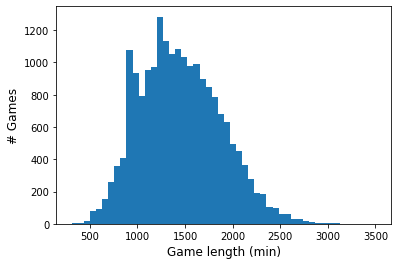

In [715]:
plt.hist(df_dropped['GameDuration'], bins = 50)
plt.xlabel('Game length (min)', fontsize = 12)
plt.ylabel('# Games', fontsize = 12)

<a id='machine'></a>
# Model Selection

In [925]:
X = df_filled.drop('Winner', axis=1)

In [926]:
y = df_filled['Winner']

In [927]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)

In [738]:
%%time
# prepare configuration for cross validation test harness
seed = 42
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)


LR: 0.510411 (0.008647)
LDA: 0.893824 (0.004370)
KNN: 0.531184 (0.008935)
CART: 0.858566 (0.005077)
NB: 0.490544 (0.005773)
SVM: 0.511719 (0.005898)


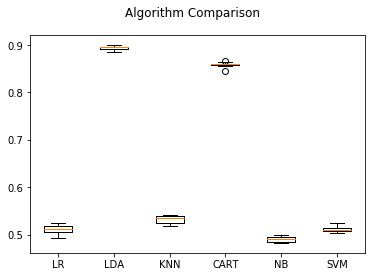

In [739]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Since ensemble method classifers seem promising from the results with DecisionTreeClassifier, train and compare ensemble method classifiers.

In [742]:
%%time
# prepare configuration for cross validation test harness
seed = 42
# prepare models
models = []
models.append(('ADA', AdaBoostClassifier()))
models.append(('BAG', BaggingClassifier()))
models.append(('RFC', RandomForestClassifier()))
models.append(('GBC', GradientBoostingClassifier()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

ADA: 0.886380 (0.006614)
BAG: 0.876622 (0.004677)
RFC: 0.888895 (0.004026)
GBC: 0.900564 (0.005460)
Wall time: 2min 16s


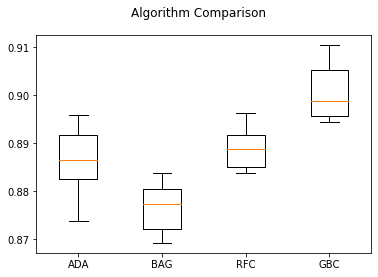

In [744]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

<a id='tuning'></a>
# Model Tuning

GradientBoostingClassifier was selected for having the highest precision and f1-score amongst the fitted classifers. GridSearchCCV was used to fine-tune the model parameters.

In [781]:
clf_GB.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [928]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer

# Initialize the classifier
clf_GB = GradientBoostingClassifier(random_state = 42)

# Create the parameters list to tune
parameters = {'n_estimators':[10, 20, 60, 100], 'learning_rate': [0.05, 0.1, 0.2, 1]}

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta = 0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(estimator = clf_GB, param_grid = parameters, scoring = scorer, cv = 5)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf_GB.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.9065
F-score on testing data: 0.9102

Optimized Model
------
Final accuracy score on the testing data: 0.9076
Final F-score on the testing data: 0.9118


# Feature Importance Extraction

In [790]:
feat_importances = pd.Series(clf_GB.feature_importances_, index=X_test.columns.values).sort_values(ascending=False)

In [968]:
def plot_barh(s_to_plot, title = '', xlabel = '', ylabel = '',
color_palette = 'YlGnBu', pre_unit = '', suff_unit = '', round_place = '',):
    '''
    Plot horizontal bar graph
    '''
    y_labels = s_to_plot.index

    # Plot the figure.
    plt.figure(figsize=(12, 20))
    ax = s_to_plot.plot(kind='barh')
    plt.barh(s_to_plot.index, s_to_plot,
            color = sns.color_palette(color_palette, len(s_to_plot.index)))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_yticklabels(y_labels)
    x_llim, x_ulim = ax.get_xlim()
    #x_ulim = xulim_set
    #ax.set_xlim(x_llim, xulim_set) # expand xlim to make labels easier to read
    plt.tight_layout()
    rects = ax.patches

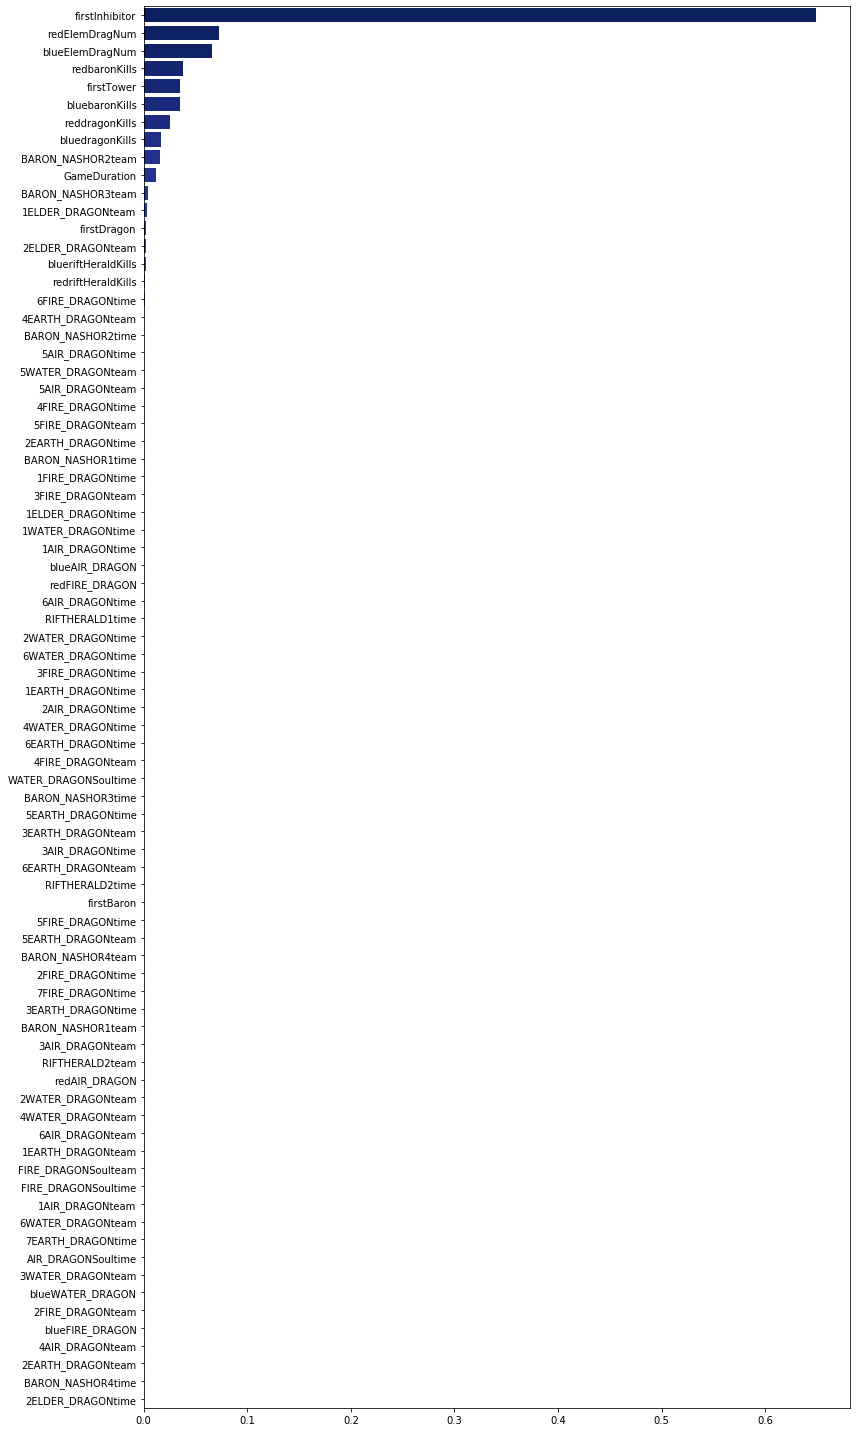

In [969]:
plot_barh(feat_importances[feat_importances > 0].sort_values())

In [971]:
pd.DataFrame(feat_importances[feat_importances > 0])

,0
firstInhibitor,6.489103e-01
redElemDragNum,7.295672e-02
blueElemDragNum,6.624017e-02
redbaronKills,3.830563e-02
firstTower,3.491930e-02
...,...
blueFIRE_DRAGON,1.690759e-05
4AIR_DRAGONteam,2.279306e-06
2EARTH_DRAGONteam,1.420384e-06
BARON_NASHOR4time,1.109049e-06


In [930]:
feat_importances[var_soul].sort_values(ascending=False)

WATER_DRAGONSoultime    0.000300
FIRE_DRAGONSoulteam     0.000099
FIRE_DRAGONSoultime     0.000098
AIR_DRAGONSoultime      0.000041
EARTH_DRAGONSoultime    0.000000
EARTH_DRAGONSoulteam    0.000000
AIR_DRAGONSoulteam      0.000000
WATER_DRAGONSoulteam    0.000000
dtype: float64

In [803]:
def feature_plot(importances, X_train, y_train):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:10]]
    values = importances[indices][:10]

    # Creat the plot
    fig = plt.figure(figsize = (9,5))
    plt.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(10), values, width = 0.2, align="center", color = '#00A000', \
          label = "Feature Weight")
    plt.bar(np.arange(10) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(10), columns)
    plt.xlim((-0.5, 4.5))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.show()  

In [972]:
feat_importances[:30]

firstInhibitor         0.648910
redElemDragNum         0.072957
blueElemDragNum        0.066240
redbaronKills          0.038306
firstTower             0.034919
bluebaronKills         0.034776
reddragonKills         0.025468
bluedragonKills        0.016608
BARON_NASHOR2team      0.015860
GameDuration           0.012358
BARON_NASHOR3team      0.004313
1ELDER_DRAGONteam      0.003248
firstDragon            0.002674
2ELDER_DRAGONteam      0.002267
blueriftHeraldKills    0.001990
redriftHeraldKills     0.001301
6FIRE_DRAGONtime       0.000944
4EARTH_DRAGONteam      0.000799
BARON_NASHOR2time      0.000766
5AIR_DRAGONtime        0.000759
5WATER_DRAGONteam      0.000759
5AIR_DRAGONteam        0.000632
4FIRE_DRAGONtime       0.000627
5FIRE_DRAGONteam       0.000594
2EARTH_DRAGONtime      0.000560
BARON_NASHOR1time      0.000545
1FIRE_DRAGONtime       0.000491
3FIRE_DRAGONteam       0.000465
1ELDER_DRAGONtime      0.000429
1WATER_DRAGONtime      0.000426
dtype: float64

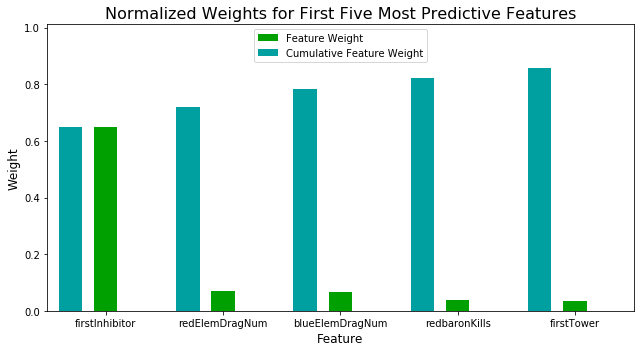

In [931]:
feature_plot(clf_GB.feature_importances_, X_train, y_train)

## Results

### Dragon Soul

The data does seem to reflect what people think of the relative power levels of dragon souls - ocean is the most powerful IF you get it early. Cloud soul also contributes towards wins if it's obtained earlier in the game. This makes sense since ocean and cloud drake both grant advantages early and mid-game, but these advantages decrease as the game goes on. Come late game, the players' stats will have scaled enough and the game's pace will change to even out these dragon soul advantages. 

Ocean soul grants extra health and mana regeneration out of combat, which will help one team stay healthy throughout midgames during skirmishes, extended seiges and teamfights. Since it boosts regeneration, ocean soul is only useful if at least some players on a team stay alive after combat. Turrets still do significant damage to players midgame, so even if not everyone on a is alive, ocean soul helps the alive players stay healthy to defend with the safety of  structures. As the game goes on, player damage will have also increased to the point that players are more likely to die and the death timers are longer. Additionally, structural defenses, turrets, do less meaningful damage to players while players can destroy them more easily. As deaths become more impactful, any player who remain alive on a team while some of their teammates are dead find that ocean soul becomes less helpful in defense. 

Cloud soul increases movement speed and cooldown reduction on spells, granting one team a tempo advantage in moving around the map and having increased access to useful ultimate spells. Player will have more CDR items and have decreased cooldowns with higher level spells, so players will be more likely to have equal access to their ultimate spells later in the game. 

Infernal soul, on the other hand, remains powerful regardless of when the team obtains it. The infernal soul grants percent-based permanent damage bonuses to a team, so that advantage remains throughout the course of a game.

The top 5 most predictive features are:
1. team that takes first inhibitor
2. number of elemental dragons taken by red team
3. number of elemental dragons taken by blue team
4. number of baron kills taken by the red team
5. team that takes first tower

Which team kills the first inhibitor seems to be the best predictor of who will win the game. This makes sense since killing an inhibitor is the most direct path towards killing the enemy nexus. The first inhibitor kill accounts for 60% of the weights for predicting the game winner. 

The total number of elemental drakes taken by a team is the next best predictor, with red team dragon kills being slightly more predictive than blue team's. Without doing further analysis it's hard to say whether this difference is statistically significant. We can speculate that perhaps the red team's larger relative distance from the dragon pit compared to the blue team means that red team naturally has less control over the dragon; therefore, if the red team is successful at capturing dragon objectives, red likely has a strong control over the game carrying over to wins.

The order of importance of neutral objectives to the game result seems to be:
#### elemental dragons > baron > elder dragon > rift herald

### Early objectives

Of all the early objectives available (inhibitor, tower, dragon, baron, rift herald), it seems that the non-neutral objectives, inhibitors and towers, are the most predictive, followed by dragon and baron. First rift herald seem to have no predictive weight on the winner at all.

Of course, the associations here must be taken with a grain of salt before tranlating them to causation. Having early game pressure will translate to more objective control. However, it is very telling that first dragon has more weight than first herald, when both of these objectives are usually captured around the same time and are often "traded" for each other (if one team takes one, the other team will take the other).

In [ ]:
bool_params = ['firstTower', 'firstInhibitor', 'firstBaron', 'firstDragon', 
               'firstRiftHerald']
num_params = ['baronKills', 'riftHeraldKills', 'dragonKills']

In [979]:
feat_importances[bool_params].sort_values(ascending=False)

firstInhibitor     0.648910
firstTower         0.034919
firstDragon        0.002674
firstBaron         0.000188
firstRiftHerald    0.000000
dtype: float64

<BarContainer object of 5 artists>

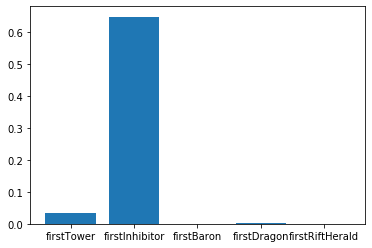

In [977]:
plt.bar(feat_importances[bool_params].index, feat_importances[bool_params])

In [757]:
X_test.columns.values

array(['GameDuration', 'firstTower', 'firstInhibitor', 'firstDragon',
       'firstRiftHerald', 'bluebaronKills', 'redbaronKills',
       'blueriftHeraldKills', 'redriftHeraldKills', 'bluedragonKills',
       'reddragonKills', 'blueElemDragNum', 'blueFIRE_DRAGON',
       'blueEARTH_DRAGON', 'redElemDragNum', 'redFIRE_DRAGON',
       'redEARTH_DRAGON', '1FIRE_DRAGONteam', '1FIRE_DRAGONtime',
       '2EARTH_DRAGONteam', '2EARTH_DRAGONtime', 'RIFTHERALD1team',
       'RIFTHERALD1time', 'firstBaron', '1ELDER_DRAGONteam',
       '1ELDER_DRAGONtime', 'blueAIR_DRAGON', 'FIRE_DRAGONSoulteam',
       'FIRE_DRAGONSoultime', 'redAIR_DRAGON', '1AIR_DRAGONteam',
       '1AIR_DRAGONtime', '3FIRE_DRAGONteam', '3FIRE_DRAGONtime',
       '4FIRE_DRAGONteam', '4FIRE_DRAGONtime', 'BARON_NASHOR1team',
       'BARON_NASHOR1time', 'blueWATER_DRAGON', 'redWATER_DRAGON',
       '1WATER_DRAGONteam', '1WATER_DRAGONtime', '2WATER_DRAGONteam',
       '2WATER_DRAGONtime', 'RIFTHERALD2team', 'RIFTHERALD2time',
     

Further work:
- adding predictions based on different points of time in the game
- perform dimensionality reduction
- expand number of matches in dataset - due to time practicality limitations, only 20,000 matches were extracted of over 60,000 match IDs obtained
- expand data to servers in other geographical regions - e.g. EU, China, Korean
- expand data to lower elos, since masters+ is a very small proportion of the playerbase and may not reflect what the predictors are in lower elo (e.g. Bronze, Silver, Gold)